#Initial pass of the dataset into an output folder.
**Modify the Path names as needed**

In [51]:
import PIL.Image as Image
import skimage.io as io
import numpy as np
import time
from gf import guided_filter
from numba import jit
import matplotlib.pyplot as plt
import warnings
import os
import shutil
from tqdm.notebook import tqdm

class HazeRemoval(object):

    # Settings the warnings to be ignored
    warnings.filterwarnings('ignore')

    def __init__(self, omega=0.95, t0=0.1, radius=7, r=20, eps=0.001):
        pass

    def open_image(self, img_path):
        img = Image.open(img_path)
        self.src = np.array(img).astype(np.double)/255.
        # self.gray = np.array(img.convert('L'))
        self.rows, self.cols, _ = self.src.shape
        self.dark = np.zeros((self.rows, self.cols), dtype=np.double)
        self.Alight = np.zeros((3), dtype=np.double)
        self.tran = np.zeros((self.rows, self.cols), dtype=np.double)
        self.dst = np.zeros_like(self.src, dtype=np.double)


    @jit
    def get_dark_channel(self, radius=7):
        print("Starting to compute dark channel prior...")
        start = time.time()
        tmp = self.src.min(axis=2)
        for i in range(self.rows):
            for j in range(self.cols):
                rmin = max(0,i-radius)
                rmax = min(i+radius,self.rows-1)
                cmin = max(0,j-radius)
                cmax = min(j+radius,self.cols-1)
                self.dark[i,j] = tmp[rmin:rmax+1,cmin:cmax+1].min()
        print("time:",time.time()-start)

    def get_air_light(self):
        print("Starting to compute air light prior...")
        start = time.time()
        flat = self.dark.flatten()
        flat.sort()
        num = int(self.rows*self.cols*0.001)
        threshold = flat[-num]
        tmp = self.src[self.dark>=threshold]
        tmp.sort(axis=0)
        self.Alight = tmp[-num:,:].mean(axis=0)
        # print(self.Alight)
        print("time:",time.time()-start)

    @jit
    def get_transmission(self, radius=7, omega=0.95):
        print("Starting to compute transmission...")
        start = time.time()
        for i in range(self.rows):
            for j in range(self.cols):
                rmin = max(0,i-radius)
                rmax = min(i+radius,self.rows-1)
                cmin = max(0,j-radius)
                cmax = min(j+radius,self.cols-1)
                pixel = (self.src[rmin:rmax+1,cmin:cmax+1]/self.Alight).min()
                self.tran[i,j] = 1. - omega * pixel
        print("time:",time.time()-start)

    def guided_filter(self, r=60, eps=0.001):
        print("Starting to compute guided filter trainsmission...")
        start = time.time()
        self.gtran = guided_filter(self.src, self.tran, r, eps)
        print("time:",time.time()-start)

    def recover(self, t0=0.1):
        print("Starting recovering...")
        start = time.time()
        self.gtran[self.gtran<t0] = t0
        t = self.gtran.reshape(*self.gtran.shape,1).repeat(3,axis=2)
        # import ipdb; ipdb.set_trace()
        self.dst = (self.src.astype(np.double) - self.Alight)/t + self.Alight
        self.dst *= 255
        self.dst[self.dst>255] = 255
        self.dst[self.dst<0] = 0
        self.dst = self.dst.astype(np.uint8)
        print("time:",time.time()-start)

    def show(self,):
        import cv2
        cv2.imwrite("img/src.jpg", (self.src*255).astype(np.uint8)[:,:,(2,1,0)])
        cv2.imwrite("img/dark.jpg", (self.dark*255).astype(np.uint8))
        cv2.imwrite("img/tran.jpg", (self.tran*255).astype(np.uint8))
        cv2.imwrite("img/gtran.jpg", (self.gtran*255).astype(np.uint8))
        cv2.imwrite("img/dst.jpg", self.dst[:,:,(2,1,0)])

        io.imsave("test.jpg",self.dst)



def run(self, img_path, img_name):
        self.open_image(img_path)
        self.get_dark_channel()
        self.get_air_light()
        self.get_transmission()
        self.guided_filter()
        self.recover()
        self.show()
        shutil.move("/content/test.jpg", img_name)
        #os.replace("/content/test.jpg", "/content/drive/MyDrive/hazeOutput")
        #os.rename('/content/drive/MyDrive/hazeOutput/test.jpg',img_name)


In [52]:
from pathlib import Path
directory = r"/content/drive/MyDrive/HazeInput"

for name in tqdm(os.listdir(directory)):

  with open(os.path.join(directory, name)) as f:

    path = directory + "/" + name
    curr_Img = HazeRemoval(path)

    array1 = path.split('_')
    array2 = array1[0].split('/')
    img_name = "/content/drive/MyDrive/hazeOutput/" + array2[-1] + "output.jpg"

    my_file = Path(img_name)

    if not my_file.exists():
      run(a,path,img_name)

  0%|          | 0/429 [00:00<?, ?it/s]

# **Use this section to test individual test cases**


In [53]:
#change path to the path of desired image
path = "/content/3139_0.95_0.2.jpg"
test_Img = HazeRemoval(path)
img_name = path + "output.jpg"
run(test_Img,path,img_name)

Starting to compute dark channel prior...
time: 3.4485368728637695
Starting to compute air light prior...
time: 0.008722543716430664
Starting to compute transmission...
time: 4.635775804519653
Starting to compute guided filter trainsmission...
time: 5.65979266166687
Starting recovering...
time: 0.018863916397094727


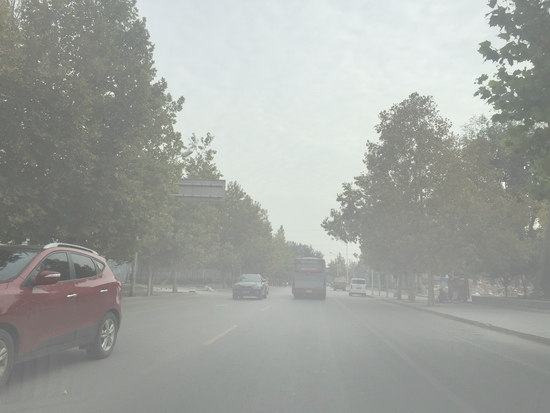

In [54]:
from IPython.display import Image
Image(path)

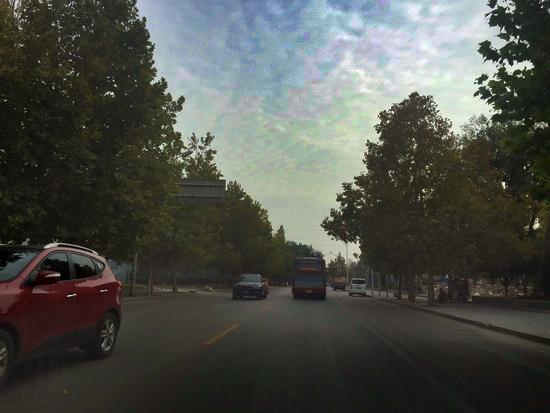

In [55]:
Image(img_name)

In [56]:
import torchvision
from torchvision.io import read_image
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

In [57]:
def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

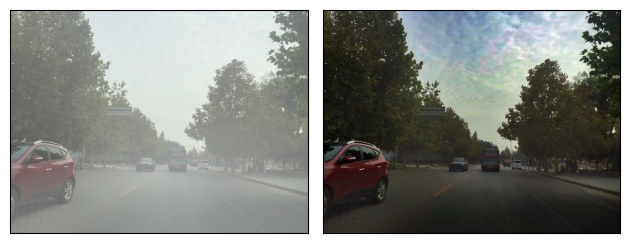

In [58]:
orig_img = read_image(path)
img_result = read_image(img_name)
plot([orig_img, img_result])